# Curious: How does the Logistic Regression model work for the XOR problem?
In this notebook, we will explore how a Logistic Regression model performs on the XOR problem, which is a classic example of a non-linearly separable dataset. We will generate the XOR dataset, fit a Logistic Regression model to it, and visualize the results.

> **Learning objectives:**
>
> In this notebook, students will learn to:
>
> * **Implement Logistic Regression on non-linearly separable data.** We apply Logistic Regression to the XOR dataset and examine how it performs when the true decision boundary is non-linear, demonstrating the limitations of linear classifiers on complex patterns.
> * **Visualize decision boundaries and classification errors.** We plot the learned linear decision boundary from Logistic Regression alongside the true XOR data distribution, highlighting misclassified points and demonstrating why linear models struggle with this problem.
> * **Understand probabilistic classification outputs.** We examine Logistic Regression's probability outputs rather than hard classifications, gaining insight into how probabilistic models provide richer information about classification confidence even when the decision boundary is suboptimal.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on Julia functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include-extra.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll use [`VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types and data used in this material.

### Constants
Next, let's set some constants we'll need for the data generation logic below. Please look at the comment next to the constant for a description of what it is, permissible values, etc.

In [6]:
number_label_one = 1000; # number of points in cloud 1 (must be ≥ 2)
number_label_two = 1000; # number of points in cloud 2 (must be ≥ 2)
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 3; # features: (x,y,l), where l is a generated label; see below.
c̄₁ = (0.0, 0.0); # center for the cloud: fixed
θ = 60*(π/180); # rotation angle (radians)

Finally, let's set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict Int64, RGB` dictionary are class labels, i.e., $ y\in\{1,-1\}$ while the values are the colors mapped to that label.

In [8]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1

### Data

Let's start with the master dataset `D::Array{Float64,2}`. This dataset will have two continuous features $\mathbf{x}\in\mathbb{R}^{2}$ and a categorical label $y\in\{-1,1\}$. We'll build a label function $L:\mathbb{R}\times\mathbb{R}\to\{\text{true, false}\}$ (we can change this function around to get different labeling patterns):

In [71]:
# TODO: uncomment this logic for different labeling patterns
# L(x,y) = (y ≥ 0) ? true : false; # rotated half circle (linearly separable)
# L(x,y) = (x ≥ 0) && (y ≥ 0) ? true : false; # wedge pattern (not linearly separable)
L(x,y) = xor(x ≥ 0,y ≥ 0); # XOR pattern alternating pie wedges (not linearly separable)

Generate the master dataset `D`:

In [73]:
D = let
    
    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedatacloud(c̄₁, number_of_points = number_label_one, label=0); # generate label 1 data
    s₂ = generatedatacloud(c̄₁, number_of_points = number_label_two, label=0); # generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the index from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end

    # compute the label by taking the XOR, OR, AND, etc functions
    for i ∈ 1:total_number_of_points
        flag = L(D[i,1],D[i,2]);
        if (flag == true)
            D[i,3] = 1
        else
            D[i,3] = -1
        end
    end

    # finally, let's rotate the data a bit (counter-clockwise)
    R = [
        cos(θ) -sin(θ) ;
        sin(θ) cos(θ) ;
    ];

    # keep the label, but apply the rotation to the (x,y) data
    D̂ = copy(D);
    for i ∈ 1:total_number_of_points
        x̂ = R*D[i,1:2];
        D̂[i,1] = x̂[1];
        D̂[i,2] = x̂[2];
    end
    
    D̂ # return the data
end;

#### Visualize dataset `D`
`Unhide` the code block below to see how we plotted the dataset `D` which contains two continuous features and a label. The color indicates the label.

> __Summary__: We will get a different pattern of $\pm{1}$ labels depending on the labeling function logic $L(x_{1},x_{2})$ we used. The dark blue dots represent label `1`, while the orange data represents label `-1`. Our classifier should be able to learn the mapping between the features and the labels for linearly separable datasets.

So what do we see?

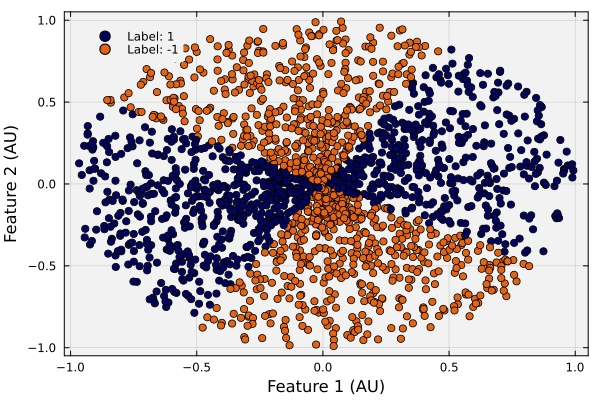

In [75]:
let

    dataset = D; # what dataset am I looking at?
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot

    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot all points
    for i ∈ 1:total_number_of_points
        label = dataset[i,3]; # label
        c = my_color_dictionary[label]
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end
    
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

Now let's split the dataset into the system input matrix $\mathbf{X}$ (independent variables) and the output vector $\mathbf{y}$ (dependent variable, the class).

In [77]:
X = D[:, 1:2]; # input matrix (independent variables)
y = D[:, 3];   # output vector (dependent variable, the class)

Finally, let's partition the data into a `training` and `testing` set so that we can determine how well the model can predict unseen data, i.e., how well the model generalizes.

In [79]:
training, testing = let

    # initialize -
    s = 0.80; # fraction of data for training
    number_of_training_samples = Int(round(s * size(X,1))); # 80% of the data for training
    i = randperm(size(X,1)); # random permutation of the indices
    training_indices = i[1:number_of_training_samples]; # first 80% of the indices
    testing_indices = i[number_of_training_samples+1:end]; # last 20% of
    

    # setup training -
    one_vector = ones(number_of_training_samples);
    training = (X=[X[training_indices, :] one_vector], y=y[training_indices]);

    # setup testing -
    one_vector = ones(length(testing_indices));
    testing = (X=[X[testing_indices, :] one_vector], y=y[testing_indices]);

    training, testing;
end;

___

## Learn the Logistic Regression Model and Classify the Data
We implemented [the `MyLogisticRegressionClassificationModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyLogisticRegressionClassificationModel), which contains data required to solve the logistic regression problem, i.e., parameters, the learning rate, a stopping tolerance parameter $\epsilon$, and a loss (objective) function that we want to minimize. 
* __Technical note__: In this implementation, we approximated the gradient calculation using [a forward finite difference](https://en.wikipedia.org/wiki/Finite_difference). In general, this is not a great idea. This is one of my super pet peeves of gradient descent; computing the gradient is usually a hassle, and we do a bunch of function evaluations to get a good approximation of the gradient. However, finite difference is easy to implement.
* __Note on the loss function__: In the code below, we use the natural logarithm `log` in the loss function. You could also use `log10`. While this differs from the mathematical derivation above (which uses natural log), it doesn't change the location of the minimum since `log10` is simply a scaled version of the natural log. The gradient descent algorithm will find the same optimal parameters $\theta$.
* In the code block below, we [build a `model::MyLogisticRegressionClassificationModel` instance using a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#Factory-methods). The model instance initially has a random guess for the classifier parameters. We use gradient descent to refine that guess [using the `learn(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.learn), which returns an updated model instance (with the best parameters that we found so far). 

We return the updated model instance and save it in the `model_logistic::MyLogisticRegressionClassificationModel` variable.

In [82]:
model_logistic = let

    # data -
    X = training.X; # feature matrix
    y = training.y; # labels
    number_of_features = size(X,2); # number of features + 1

    # model
    model = build(MyLogisticRegressionClassificationModel, (
        parameters = 0.01*ones(number_of_features), # initial value for the parameters: these will be updated
        learning_rate = 0.005, # you pick this
        ϵ = 1e-6, # you pick this (this is also the step size for the fd approx to the gradient)
        loss_function = (x,y,θ) -> log(1+exp(-2*y*(dot(x,θ)))) # what??!? Wow, that is nice. Yes, we can pass functions as args!
    ));

    # train -
    model = learn(X,y,model, maxiter = 20000, verbose = true); # this is learning the model parameters

    # return -
    model;
end;

Stopped after number of iterations: 20001. We have error: 1550.4743981366532


Let's use the updated `model_logistic::MyLogisticRegressionClassificationModel` instance (that has learned some parameters from the `training` data) and test how well we classify data that we have never seen, i.e., how well we classify the `test` dataset.

__Inference__: We run the classification operation on the (unseen) test data [using the `classify(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.classify). This method takes a feature array `X` and the (trained) model instance. It returns the probability of a label in the `P::Array{Float64,2}` array (which is different than the Perceptron). Each row of `P` corresponds to a test instance, in which each column corresponds to a label, in the case `1` and `-1`.

We store the actual (correct) label in the `y_banknote_logistic::Array{Int64,1}` vector. We compute the predicted label for each test instance by finding the highest probability column. We store the predicted labels in the `ŷ_banknote_logistic::Array{Int64,1}` vector.

In [84]:
ŷ_logistic,y_logistic, P = let

    # initialize -
    X = testing.X; # feature matrix
    y = testing.y; # labels
    number_of_examples = size(X,1); # how many examples do we have (rows)
    number_of_features = size(X,2); # how many features do we have (cols) + 1

    # compute the estimated labels -
    P = classify(X, model_logistic) # logistic regression returns a x x 2 array holding the probability

    # convert the probability to a choice ... for each row (test instance), compute the col with the highest probability
    ŷ = zeros(number_of_examples);
    for i ∈ 1:number_of_examples
        a = argmax(P[i,:]); # col index with largest value
        ŷ[i] = 1; # default
        if (a == 2)
            ŷ[i] = -1;
        end
    end
    
    # return -
    ŷ, y, P
end;

### Confusion Matrix
Let's now compute the __confusion matrix__. The confusion matrix for a binary classifier is typically structured as follows:

|                     | **Predicted Positive** | **Predicted Negative** |
|---------------------|------------------------|------------------------|
| **Actual Positive** | True Positive (TP)     | False Negative (FN)    |
| **Actual Negative** | False Positive (FP)    | True Negative (TN)     |

We've implemented [the `confusion(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification/#VLDataScienceMachineLearningPackage.confusion) to compute the confusion matrix given the actual and predicted labels. Let's save the confusion matrix in the `CM_logistic::Array{Int64,2}` variable and compute the accuracy of the classifier on the test data

In [86]:
CM_logistic = confusion(y_logistic, ŷ_logistic)

2×2 Matrix{Int64}:
 1  198
 0  201

__Visualize the misses__. Using the test dataset, let's show (with gray circles) which samples our classifier is unable to predict the label correctly, i.e., where we miss the label.

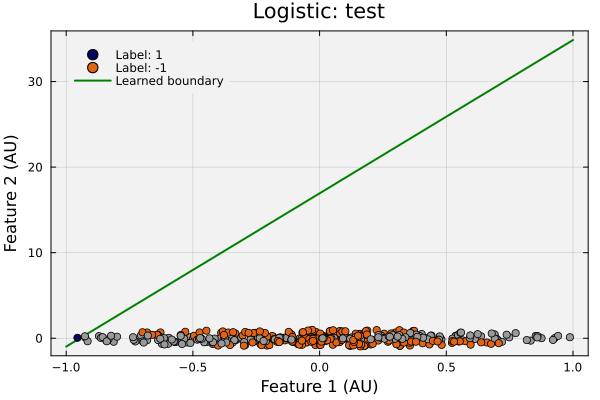

In [88]:
let

    model = model_logistic; # which model am I using?
    X = testing.X; # what dataset am I looking at?
    y = testing.y;
    caselabel = "test";
    actual = y_logistic;
    predicted = ŷ_logistic;
    number_of_points = size(X,1); # number of rows
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  y)
    c = my_color_dictionary[testlabel]
    scatter!([X[i,1]], [X[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  y)
    c = my_color_dictionary[testlabel]
    scatter!([X[i,1]], [X[i,2]], label="Label: $(testlabel)", c=c)

    # let's draw the separating hyperplane (in our case, a line)
    p = model.β;
    number_of_plane_points = 200;
    x₂ = zeros(number_of_plane_points);
    x₁ = range(-1,stop=1,length = number_of_plane_points) |> collect;
    for i ∈ 1:number_of_plane_points
        x₂[i] = -1*((p[1]/p[2])*x₁[i] + p[3]/p[2]);
    end
    plot!(x₁,x₂,lw=2, c=:green, label="Learned boundary")
    
    # data -
    for i ∈ 1:number_of_points
        actuallabel = actual[i]; # actual label
        testlabel = predicted[i]; # predicted label

        c = :gray60;
        if (actuallabel == testlabel)
            c = my_color_dictionary[actuallabel]
        end
        scatter!([X[i, 1]], [X[i, 2]], label="", mec=:navy, c=c)
    end

    title!("Logistic: $(caselabel)", fontsize=18)
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

___

## Summary
In this notebook, we explored how Logistic Regression performs on the XOR problem, a classic non-linearly separable dataset that challenges linear classifiers.

> **Key takeaways:**
> * **Logistic Regression provides probabilistic outputs but still fails on XOR.** Logistic Regression offers richer probabilistic information about classification confidence, but it still cannot learn the non-linear XOR decision boundary, resulting in classification errors on this problem.
> * **Visualizing decision boundaries reveals fundamental limitations.** The linear decision boundary learned by Logistic Regression demonstrates that no single hyperplane can correctly separate all XOR data points, regardless of the probabilistic framework used.
> * **Understanding classifier limitations motivates advanced methods.** Recognizing that Logistic Regression fails on XOR motivates the development of non-linear classifiers, including neural networks with hidden layers, kernel methods, and ensemble techniques that can learn complex decision boundaries.

__Where do we go from here?__ The limitations we observed with linear classifiers on non-linearly separable problems like XOR motivated the development of multi-layer neural networks and other non-linear methods. These approaches can learn arbitrary decision boundaries by applying non-linear transformations to input features, which we'll explore in more advanced courses, e.g., 5820!
___